Fitting 3 folds for each of 243 candidates, totalling 729 fits
Meilleurs paramètres : {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Modèle sauvegardé dans : C:\Users\rouat\Desktop\final\train\best_xgb_model.pkl
Évaluation sur le jeu de validation :
              precision    recall  f1-score   support

         1.0       0.60      0.31      0.41       117
         2.0       0.82      0.90      0.86      1149
         3.0       0.50      0.26      0.34       644
         4.0       0.64      0.80      0.71      1085
         5.0       0.57      0.72      0.64        78
         6.0       0.72      0.50      0.59       127
         7.0       0.99      1.00      1.00      2176

    accuracy                           0.82      5376
   macro avg       0.69      0.64      0.65      5376
weighted avg       0.80      0.82      0.80      5376

Évaluation sur le jeu de test :
              precision    recall  f1-score   support

         1

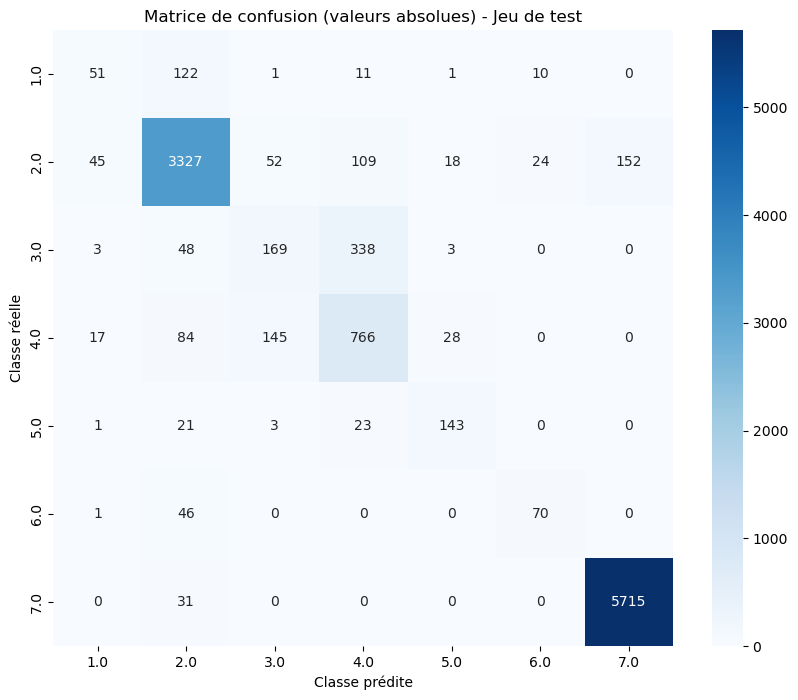

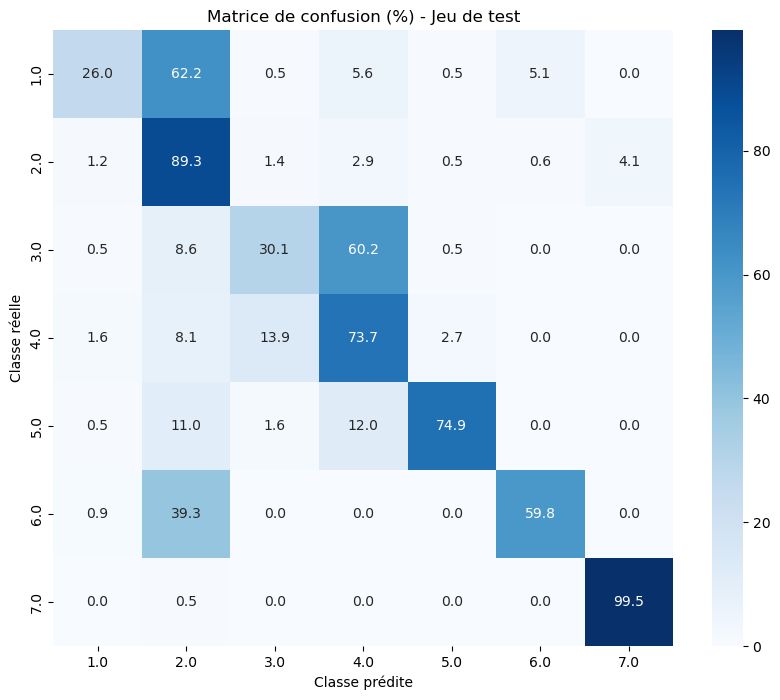

In [ ]:
#Classification des comportements avec XGBoost sur données non augmentées
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Fichiers train, val et test
train_file = r"C:\Users\rouat\Desktop\final\train\annotations_train_scaled.txt"
val_file   = r"C:\Users\rouat\Desktop\final\val\annotations_val_scaled.txt"
test_file  = r"C:\Users\rouat\Desktop\final\test\annotations_test_scaled.txt"

# Charger les datasets
train_df = pd.read_csv(train_file, sep=' ')
val_df   = pd.read_csv(val_file, sep=' ')
test_df  = pd.read_csv(test_file, sep=' ')

# Colonnes features à utiliser pour le modèle

feature_cols = ['x_center', 'y_center', 'width', 'height',
                'aspect_ratio', 'interframe_distance',
                'velocity', 'velocity_direction',
                'acceleration', 'acceleration_direction',
                'interframe_distance_mean', 'interframe_distance_max', 'interframe_distance_min', 'interframe_distance_std',
                'velocity_mean', 'velocity_max', 'velocity_min', 'velocity_std',
                'velocity_direction_mean', 'velocity_direction_max', 'velocity_direction_min', 'velocity_direction_std',
                'acceleration_mean', 'acceleration_max', 'acceleration_min', 'acceleration_std',
                'acceleration_direction_mean', 'acceleration_direction_max', 'acceleration_direction_min', 'acceleration_direction_std']

# Séparer features et labels
X_train = train_df[feature_cols]
y_train = train_df['behavior']
X_val   = val_df[feature_cols]
y_val   = val_df['behavior']
X_test  = test_df[feature_cols]
y_test  = test_df['behavior']


unique_labels = sorted(y_train.unique())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

y_train_mapped = y_train.map(label_to_index)
y_val_mapped   = y_val.map(label_to_index)
y_test_mapped  = y_test.map(label_to_index)


# Hyperparameter tuning avec GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(unique_labels),
    random_state=42,
    eval_metric='mlogloss'
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Entraînement 
grid_search.fit(X_train, y_train_mapped)


best_model = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)

# Sauvegarde du modèle 
model_path = os.path.join(os.path.dirname(train_file), "best_xgb_model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(best_model, f)
print(f"Modèle sauvegardé dans : {model_path}")

# Évaluation sur le jeu de validation
y_val_pred_mapped = best_model.predict(X_val)
y_val_pred = pd.Series(y_val_pred_mapped).map(index_to_label)

print("Évaluation sur le jeu de validation :")
print(classification_report(y_val, y_val_pred))

# Évaluation sur le jeu de test
y_test_pred_mapped = best_model.predict(X_test)
y_test_pred = pd.Series(y_test_pred_mapped).map(index_to_label)

print("Évaluation sur le jeu de test :")
print(classification_report(y_test, y_test_pred))

# Matrice de confusion en valeurs absolues
cm = confusion_matrix(y_test, y_test_pred, labels=unique_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')
plt.title('Matrice de confusion (valeurs absolues) - Jeu de test')
plt.show()


# Matrice de confusion en pourcentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # pourcentage par ligne

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')
plt.title('Matrice de confusion (%) - Jeu de test')
plt.show()
